In [1]:
import os

import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

# Implementation and Training of VideoColorizer UNet model

First without optical flow


Inputs:
- previous frame: L, ab channels
- current frame: L channel

Outputs:
- current frame: ab channels

In [2]:
def cartToPol(x, y):  #convert cartesian to polar coordinates (for optical flow)
    ang = np.arctan2(y, x)
    mag = np.hypot(x, y)
    return mag, ang

def uv_2_rgb(image_uv, resize=False):
    uv_shape = image_uv.shape
    hsv = np.zeros((uv_shape[0], uv_shape[1], 3))
    hsv[..., 1] = 255

    # Encoding: convert the algorithm's output into Polar coordinates
    mag, ang = cartToPol(image_uv[..., 0], image_uv[..., 1])
    # Use Hue and Value to encode the Optical Flow
    hsv[..., 0] = (ang+np.pi) * 180 / ( 2 * np.pi )
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    #print(hsv)
    hsv = np.round(hsv).astype(np.uint8)
    #print(hsv)
    # Convert HSV to RGB (BGR) color representation
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

## 1. Data Loading

In [3]:
from DataLoad import CustomImageDataset

/home/jansp/miniconda3/envs/colorize/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
dataset = CustomImageDataset(resolution='180p')

vid labels: ['basketball-game', 'bmx-rider', 'butterfly', 'car-competition', 'cat', 'chairlift', 'circus', 'dog-competition', 'dolphins-show', 'drone-flying', 'ducks', 'giraffes', 'gym-ball', 'helicopter-landing', 'horse-race', 'hurdles-race', 'ice-hockey', 'jet-ski', 'juggling-selfie', 'kids-robot', 'mantaray', 'mascot', 'motorbike-race', 'obstacles', 'plane-exhibition', 'robot-battle', 'snowboard-race', 'swimmer', 'tram', 'trucks-race']


In [5]:
dataset_size = len(dataset)
print('Dataset size:', dataset_size)

Dataset size: 2264


In [10]:
input, output = dataset.__getitem__(565)

print(input.shape)
col_img = input.numpy()[:, :, 0:3]
flow_img = input.numpy()[:, :, 3:5]
grey_img = input.numpy()[:, :, 5:6]

print(col_img.shape)
print(flow_img.shape)
print(grey_img.shape)

print(np.min(col_img[:,:,0]), np.max(col_img[:,:,0]))
print(np.min(col_img[:,:,1]), np.max(col_img[:,:,1]))
print(np.min(col_img[:,:,2]), np.max(col_img[:,:,2]))

print(np.min(flow_img[:,:,0]), np.max(flow_img[:,:,0]))
print(np.min(flow_img[:,:,1]), np.max(flow_img[:,:,1]))

print(np.min(grey_img[:,:,0]), np.max(grey_img[:,:,0]))

print("\n")
col_img  = (col_img*255).astype(np.uint8)

print(np.min(col_img[:,:,0]), np.max(col_img[:,:,0]))
print(np.min(col_img[:,:,1]), np.max(col_img[:,:,1]))
print(np.min(col_img[:,:,2]), np.max(col_img[:,:,2]))

torch.Size([180, 320, 6])
(180, 320, 3)
(180, 320, 2)
(180, 320, 1)
0.003921569 1.0
0.32156864 0.72156864
0.21176472 0.62352943
-1.4733852 1.0419266
-0.7067611 0.34590164
0.0 1.0


1 255
82 184
54 159


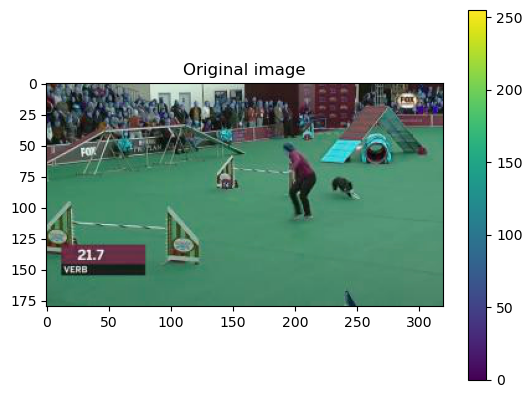

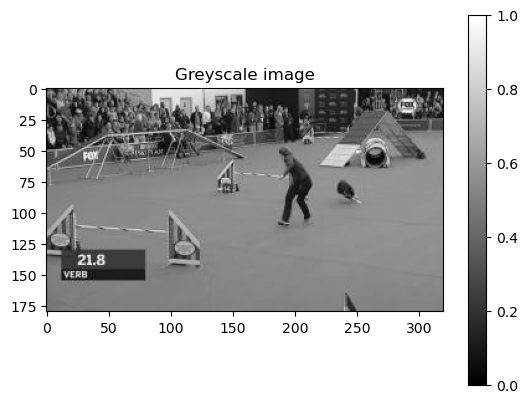

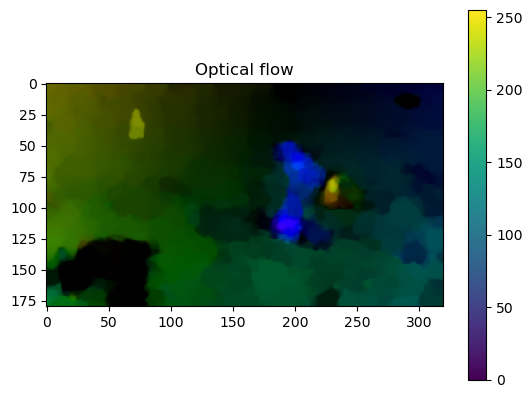

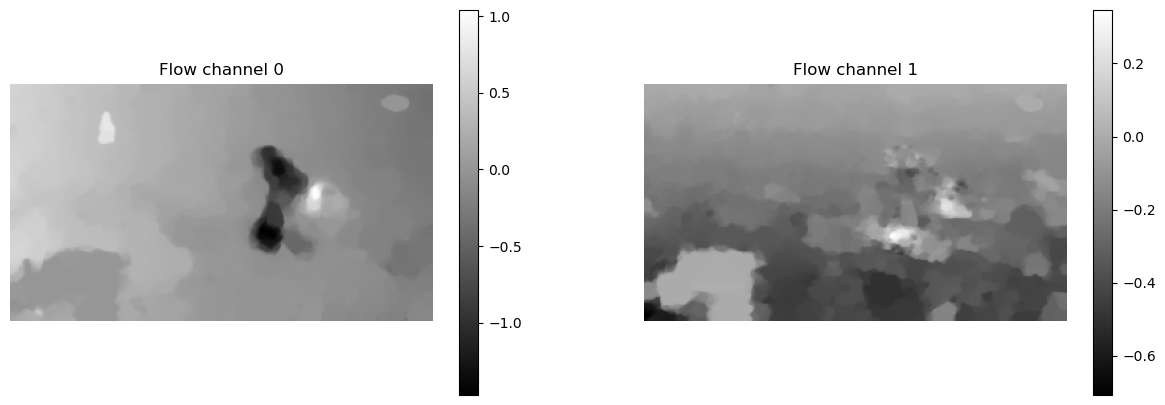

In [11]:
col_image = cv2.cvtColor(col_img, cv2.COLOR_LAB2RGB)

im = plt.imshow(col_image)
cbar = plt.colorbar(im)
plt.title('Original image')
plt.show()

im = plt.imshow(grey_img, cmap='gray')
cbar = plt.colorbar(im)
plt.title('Greyscale image')
plt.show()

flow_rgb = uv_2_rgb(flow_img)

im = plt.imshow(flow_rgb)
cbar = plt.colorbar(im)
plt.title('Optical flow')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in enumerate(axs):
    ax[1].axis('off')
    ax[1].set_title('Flow channel ' + str(ax[0]))
    im = ax[1].imshow(flow_img[:, :, ax[0]], cmap='gray')
    cbar = fig.colorbar(im, ax=ax[1])
    
plt.show()

## 2. Model Definition

In [8]:
from Model_UNet import UNet

torch.cuda.is_available()

False